<a href="https://colab.research.google.com/github/annabond1001/neural-style-transfer/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utility functions to read, plot & save images
---



In [0]:
from PIL import Image
import numpy as np

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import subplot

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

def imread(img_path): 
  img = Image.open(img_path)
  max_dim = 500.0
  scale = max_dim/max(img.size)
  scale_size = (int(img.size[0] * scale), int(img.size[1] * scale))
#   scale_size = (300,300)
  img = img.resize(scale_size, Image.ANTIALIAS)
  img = np.array(img)
  return img

def imwrite(img, img_path):
  img = Image.fromarray(img)
  img.save(img_path)
  
def imshow(img, title=None):
  if img.shape[0] == 1:
    img = np.squeeze(img, axis=0)
  plt.imshow(img)
  if title != None:
    plt.title(title)

def pyimshow(img, n_row=1, n_col=1, pos=1, title=None):
  if img.shape[0] == 1:
    img = np.squeeze(img, axis=0)
  ax = subplot(n_row, n_col, pos)
  ax.imshow(img)
  if title != None:
    plt.title(title)
    
# plt.figure(figsize=(10,10))
# img_path = '/tmp/data/building.jpg'
# img = imread(img_path)
# imshow(img)
# plt.show()


---



In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

tf.enable_eager_execution()
print("Eager execution status: {}".format(tf.executing_eagerly()))


Eager execution status: True


Check Keras VGG model: predict right labels to verify image's input format
---



In [0]:
#Testing VGG-19 model from keras
TEST_VGG = False
if TEST_VGG:
  vgg = tf.keras.applications.vgg19.VGG19(include_top=True, weights='imagenet')
  # model = models.Model(vgg.input, [vgg.get_layer('block5_conv2').output])
  model = models.Model(vgg.input, [vgg.output])
  # model = models.Model(vgg.input, [vgg.get_layer('predictions').output])

  print model.summary()

  img = content_img.copy()
  # img = process_image(img)
  img = Image.fromarray(img.astype('uint8'))
  img = img.resize((224,224))
  img = np.array(img)
  img = np.expand_dims(img, axis=0)

  output = model.predict(img)
  max_id = np.argmax(output[0])

  imshow(img)
  print max_id, output[0][max_id]

Loss function definitions
---



In [4]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layer_names = ['block5_conv2']
style_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
output_layer_names = content_layer_names + style_layer_names

content_layers = [vgg.get_layer(l_name).output for l_name in content_layer_names]
style_layers = [vgg.get_layer(l_name).output for l_name in style_layer_names]
output_layers = content_layers + style_layers

n_content_layers = len(content_layers)
n_style_layers = len(style_layers)

model = models.Model(vgg.input, output_layers)

def get_content_loss(gt_features, pred_features):
#   return tf.reduce_mean(tf.losses.mean_squared_error(gt_features, pred_features))
  return tf.reduce_mean(tf.losses.mean_squared_error(gt_features, pred_features))

def get_style_loss(gt_features, pred_features):
  def get_gram_matrix(features):
    f_shape = features.get_shape().as_list()
    features = tf.reshape(features, (-1, f_shape[3]))
    n = features.get_shape().as_list()[0]
    g = tf.matmul(features, features, transpose_a=True) / tf.cast(n, tf.float32)
    return g

  gt_gram_features = get_gram_matrix(gt_features)
  pred_gram_features = get_gram_matrix(pred_features)
  return tf.reduce_mean(tf.losses.mean_squared_error(gt_gram_features, pred_gram_features))

def pre_process_img(img, is_array=False):
  if is_array:
    if len(img.shape) == 3:
      img = np.expand_dims(img, axis=0)
    if img.dtype != 'float32':
      img = img.astype('float32')
  else:
    if len(img.get_shape().as_list()) == 3:
      img = tf.expand_dims(img, axis=0)
    if img.dtype != 'float32':
      img = tf.cast(img, tf.float32)
  return img

def get_features(img):
  features = model(img)
  content_features = features[:n_content_layers]
  style_features = features[n_content_layers:]
  return {'content': content_features, 'style':style_features}
  
CHECK_FEATURES = False
if CHECK_FEATURES:
  img = content_img.copy()
  features = get_features(content_img)
  # features = get_features(style_img)

  output = features['style']
  # print([o.shape for o in output])

  fig = plt.figure(figsize=(len(output)*5,5))
  for i,o in enumerate(output):
    plt.subplot(1,len(output),i+1)
    imshow(np.amax(o[0], axis=2), output_layer_names[i])
  plt.show()

Instructions for updating:
Colocations handled automatically by placer.


Optimize the content & style losses
---



In [0]:
from tqdm import tqdm

def run_style_transfer(content_img_path, style_img_path, n_iters=1001, log_interval=10000):
  content_img = imread(content_img_path)
  style_img = imread(style_img_path)

  gt_content_features = get_features(pre_process_img(content_img, is_array=True))['content']
  gt_style_features = get_features(pre_process_img(style_img, is_array=True))['style']

  def compute_loss(content_features, style_features, content_wt, style_wt):
    content_loss = 0
    for i in range(n_content_layers):
      content_loss += get_content_loss(gt_content_features[i], content_features[i])
    content_loss /= n_content_layers

    style_loss = 0
    for i in range(n_style_layers):
      style_loss += get_style_loss(gt_style_features[i], style_features[i])
    style_loss /= n_style_layers

    total_loss = content_wt * content_loss + style_wt * style_loss
    return {'total':total_loss, 'content':content_loss, 'style':style_loss}

  content_wt = 1
  style_wt = 10e+2

  n_outputs = n_iters/log_interval + 1
  fig = plt.figure(figsize=(6*n_outputs, 6))

  input_img = content_img.copy()
  input_img = pre_process_img(input_img, is_array=True)
  input_img = tfe.Variable(input_img, dtype=tf.float32, trainable = True)

  optimizer = tf.train.AdamOptimizer(learning_rate=5)

  prev_img = input_img.numpy()

  for iter_id in tqdm(range(1,n_iters+1)):
#   for iter_id in (range(1, n_iters)):
    with tf.GradientTape() as grad_tape:
      features = get_features(input_img)
      content_features = features['content']
      style_features = features['style']
  #     grad_tape.watch(input_img)
      loss = compute_loss(content_features, style_features, content_wt, style_wt)
    grads = grad_tape.gradient(loss['total'], input_img)
    optimizer.apply_gradients([(grads, input_img)])

    prev_img = input_img.numpy()
    input_img.assign(tf.clip_by_value(input_img, np.array([0.0, 0.0, 0.0]),np.array([255.0, 255.0, 255.0])))

  #     print iter_id, " ->> ",tf.reduce_mean(tf.square(prev_img - input_img.numpy())).numpy()

    if iter_id % log_interval == 0 :
      print "Iter: ",iter_id
      print loss['total'].numpy(), loss['content'].numpy(), loss['style'].numpy()
      title = "Iter: {}| content loss: {:.2f}| style loss: {:.2f}".format(iter_id, loss['content'].numpy(), loss['style'].numpy())
  #     pyimshow(input_img.numpy()/255.0, 1, n_outputs, iter_id/log_interval + 1, title)
      plt.figure(figsize=(8,8))
      imshow(input_img.numpy()/255.0, title)
      plt.show()
  return input_img.numpy()/255.0
  # plt.show()

Download Content & Style images
---



In [6]:
!mkdir -p /tmp/data

# !wget -O /tmp/data/building.jpg https://dynaimage.cdn.cnn.com/cnn/w_768,h_1024,c_scale/https%3A%2F%2Fdynaimage.cdn.cnn.com%2Fcnn%2Fx_0%2Cy_50%2Cw_1780%2Ch_2374%2Cc_crop%2Fhttps%253A%252F%252Fstamp.static.cnn.io%252F5c363ff94db3d70020c01c79%252F190104095802-the-leonardo-africa-tower.jpg
# !wget -O /tmp/data/peacock.jpg https://orlando-rising.com/wp-content/uploads/2017/09/peacock-750x400.jpg
# !wget -O /tmp/data/scenery.jpg http://gallerystreetsville.ca/wp-content/uploads/2018/05/Painting-1024x663.jpg
# !wget -O /tmp/data/lion.jpg https://timedotcom.files.wordpress.com/2018/12/lion-conservators-center.jpg
!wget -O /tmp/data/butterfly.jpg http://www3.canisius.edu/~grandem/butterflylifecycle/Viceroy%202.jpg
# !wget -O /tmp/data/starry_night.jpg https://www.irishtimes.com/polopoly_fs/1.3334998.1514975827!/image/image.jpg_gen/derivatives/box_620_330/image.jpg
!wget -O /tmp/data/style_wave.jpg https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
# !wget -O /tmp/data/red_flowers.jpg https://data.whicdn.com/images/53611289/large.jpg
# !wget -O /tmp/data/under_water.jpg https://www.paintingwithdiamondskits.com/assets/images/Dolphin%20Reef%20Painting.jpg
# !wget -O /tmp/data/red_abstract.jpg https://a.1stdibscdn.com/nestor-toro-paintings-red-abstract-landscape---bold,-acrylic-painting-on-canvas-for-sale/archivesE/upload/a_8021/1519623941468/18988_gr7bct7ra7ptj046vlujmdvlm6_n07GITOZWI2m4dK4_1_master.jpg?width=768
!wget -O /tmp/data/abstract1.jpg http://static1.squarespace.com/static/59e53712f6576eb982bec744/59ee786ae5dd5b689c85a20b/5af2076d70a6adc5986ee549/1525811189619/7d315291f5fbf2ddc20bfd4ae1f3dcd7--paintings-of-nature-pop-art-paintings.jpg?format=1500w
!ls -l /tmp/data/

--2019-05-23 18:52:47--  http://www3.canisius.edu/~grandem/butterflylifecycle/Viceroy%202.jpg
Resolving www3.canisius.edu (www3.canisius.edu)... 138.92.8.40
Connecting to www3.canisius.edu (www3.canisius.edu)|138.92.8.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102405 (100K) [image/jpeg]
Saving to: ‘/tmp/data/butterfly.jpg’

/tmp/data/butterfly 100%[===================>] 100.00K  --.-KB/s    in 0.1s    

2019-05-23 18:52:47 (689 KB/s) - ‘/tmp/data/butterfly.jpg’ saved [102405/102405]

--2019-05-23 18:52:49--  https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2684586 (2.6M) [image/jpeg]
Saving to: ‘/tmp/data/style_wave.jpg’

/tmp/data/style_wav 100%[===================>]   2.56M  --.-K

Run Style-Transfer
---



  0%|          | 0/600 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████| 600/600 [01:28<00:00,  7.01it/s]


<Figure size 432x432 with 0 Axes>

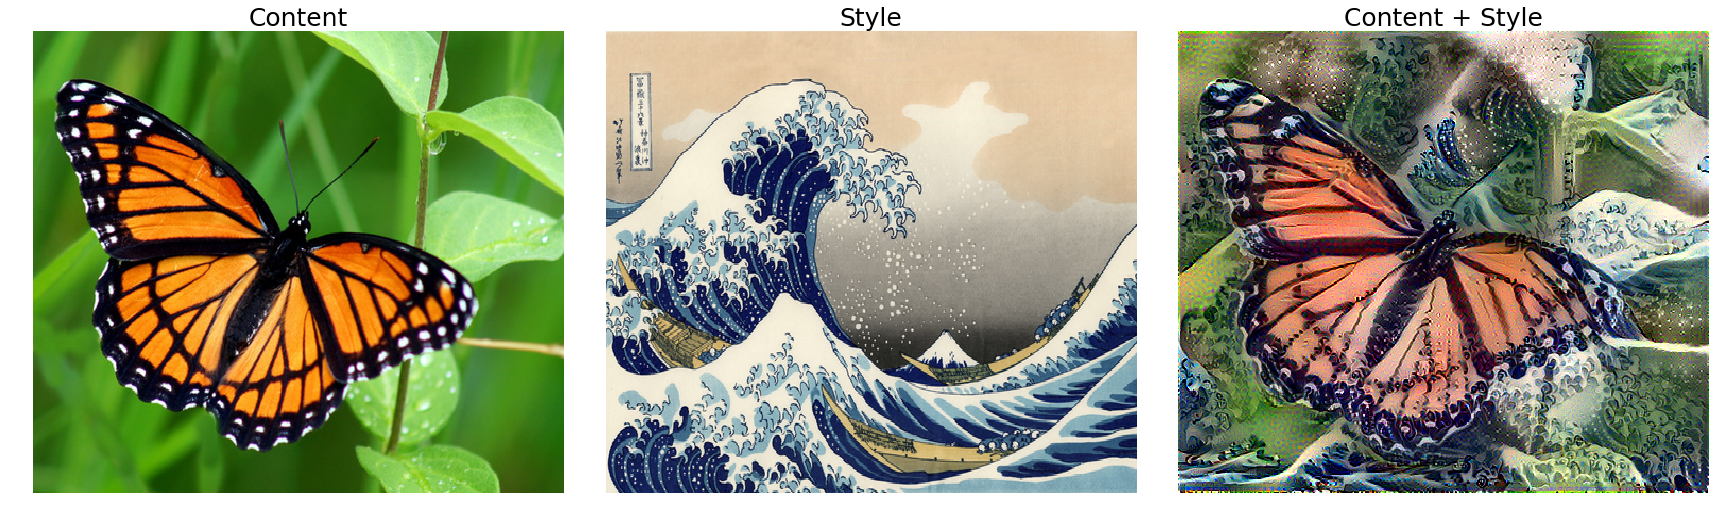

In [7]:

content_img_path = '/tmp/data/butterfly.jpg'
# style_img_path = '/tmp/data/starry_night.jpg'
style_img_path = '/tmp/data/style_wave.jpg'
# style_img_path = '/tmp/data/under_water.jpg'
# style_img_path = '/tmp/data/abstract1.jpg'

# from google.colab import files
# uploaded = files.upload()
# content_img_path = uploaded.keys()[0]
# print(content_img_path)

content_img = imread(content_img_path)
style_img = imread(style_img_path)

output_img = run_style_transfer(content_img_path, style_img_path, 600)
output_img = output_img[0]


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*8,7))
plt.tight_layout()
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax1.imshow(content_img, aspect='auto');
ax1.set_title('Content',fontsize=25)
ax2.imshow(style_img, aspect='auto');
ax2.set_title('Style',fontsize=25)
ax3.imshow(output_img, aspect='auto');
ax3.set_title('Content + Style',fontsize=25)

plt.show()

# fig = plt.figure(figsize=(3*7,7))
# plt.axis('off')

# plt.subplot(1,3,1)
# imshow(content_img,"content")
# plt.subplot(1,3,2)
# imshow(style_img,"style")
# plt.subplot(1,3,3)
# imshow(output_img, "content + style")

# plt.show()